# Test statistic and p-value assignment

Recall that any fixed classification rule that does not use a training set to tune its parameters can be converted to a statistical test. For that we must fix a null hypothesis as a source of negative samples and measure the false positive rate.
Usually, a classifier internally computes a decision value $t$ aka test score. Thus we can assign a false positive rate $p(t)$ for each threshold value $t$. This value is known as p-value.

In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats
import numpy.random as rnd
import matplotlib.pyplot as plt


from pandas import Series
from pandas import DataFrame
from keras.optimizers import Adam
from keras import layers

from tqdm.auto import tqdm
from plotnine import *

from convenience import display_source

## I. Formal definition of a p-value

Let $t$ be a test statistic computed from a sample $\boldsymbol{x}$ as $f(\boldsymbol{x})$. Let $\mathcal{D}$ be the distribution of $\boldsymbol{x}$ determined by the null hypotesis. Then p-value is a probability

\begin{align*}
\mathrm{pvalue}(t)=\Pr[\boldsymbol{x}_*\gets\mathcal{D}, t_*=f(\boldsymbol{x}_*): t_*\geq t]\enspace.
\end{align*}

Note that this definition corresponds to a classifier that classifies all samples $\boldsymbol{x}$ as negatives if $f(\boldsymbol{x})\geq t$ and $\mathrm{pvalue}(t)$ is just the fraction of false positives.

Obviously, we can reverse the classification rule and then  p-value is a probability

\begin{align*}
\mathrm{pvalue}(t)=\Pr[\boldsymbol{x}_*\gets\mathcal{D}, t_*=f(\boldsymbol{x}_*): t_*\leq t]\enspace.
\end{align*}

Both definitions are quite common. Intuitively, you should fix the direction based on the extremeness. 
If you consider larger values more extreme then you should consider the first formula. It is also possible to use a double threshold and consider a cut-off based on $|t|$. This leads to the third formula:

\begin{align*}
\mathrm{pvalue}(t)=\Pr[\boldsymbol{x}_*\gets\mathcal{D}, t_*=f(\boldsymbol{x}_*): |t_*|\geq |t|]\enspace.
\end{align*}

## Statistical power of a test

Different classification algorithms are good for different tasks. The same is true for statistical tests.
Thresholding based on p-value allows us to control the ratio of false positives (significance level).
At the same time, it also affects the ratio of false negatives. The latter is harder to quantify as it depends on two factors:
* definition of a test statistic (*statistical test*)
* the data distribution of positive cases (*alternative hypothesis*)

Of course, a test cannot really work equally good for all alternative hypotheses.
Hence, a statistical test is commonly defined to work well for all reasonable alternative hypotheses.
For instance, let the null hypothesis be that the iid (independent and identically distributed) data sample is from a normal distibution $\mathcal{N}(\mu=0,\sigma=1)$. Then it makes sense to consider a class of alternative hypotheses where the iid data sample is from a normal distribution $\mathcal{N}(\mu\neq 0,\sigma=1)$. 
This situation naturally arises in quality control where we must check that some physical quantity is zero and the measurement procedure is corrupted by additive Gaussian noise $\mathcal{N}(\mu=0,\sigma=1)$. 

Now for any alternative hypothesis specified by a distribution $\mathcal{D}$, we can compute the recall probability as follows:

\begin{align*}
\Pr[data\gets \mathcal{D}: \text{test accepts }]\enspace.
\end{align*}

This is known as **power** of the statistical test. A good test has large recall for alternative hypotheses. 
For our example case, the latter cannot be achieved since $\mathcal{N}(\mu\neq 0,\sigma=1)$ can be arbitrarily close to 
$\mathcal{N}(\mu=0,\sigma=1)$. In general, the best we can achieve is that for all the alternative hypotheses, our test performs roughly as well as the best test designed for that null hypothesis and alternative hypothesis pair.

## II. Null hypothesis and test statistic for MNIST data

Let us be down to earth and consider a practical application. Assume that you need to detect all  numbers in an hand written note. For simplicity, assume that somebody has already selected $28\times 28$ pixel patches that may contain numbers. Then you can state obvious null hypothesis.

**Invalid null hypothesis:** The image patch does not contain any numbers.

However, this is not a valid bull hypothesis as it does not fix a probability distribution over $28\times 28$ images. To convert it to null hypothesis, we have two alternatives:

* We program image generator that faithfully simulates empty $28\times 28$ patches on typical handwritten notes.
* We fix a large set of example images that do not contain numbers and are generated by processing large set of typical handwritten notes.   We get distribution by randomly sampling the set of images. 

Neither of these tasks are easy to accomplish. Hence, we study a simpler problem for which we can use MNIST dataset. Our goal will be to detect nonzero numbers and the corresponding null hypothesis is following.

**Actionable null hypothesis:** The image patch is randomly chosen from the MNIST images that are labelled as zero.

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

In [3]:
zeroes = tf.concat([train_images[train_labels == 0], test_images[test_labels == 0]], axis=0)

In [4]:
def sample_from_null_hypothesis(count: int):
    
    n = len(zeroes)
    # Sample with replacement from range(n) with uniform probability
    # Formally, we sample from sorfmax distribution with equal activations  
    index = tf.squeeze(tf.random.categorical(logits= tf.zeros([1, n]), num_samples=count, dtype='int32'))
    return tf.gather(zeroes, index)

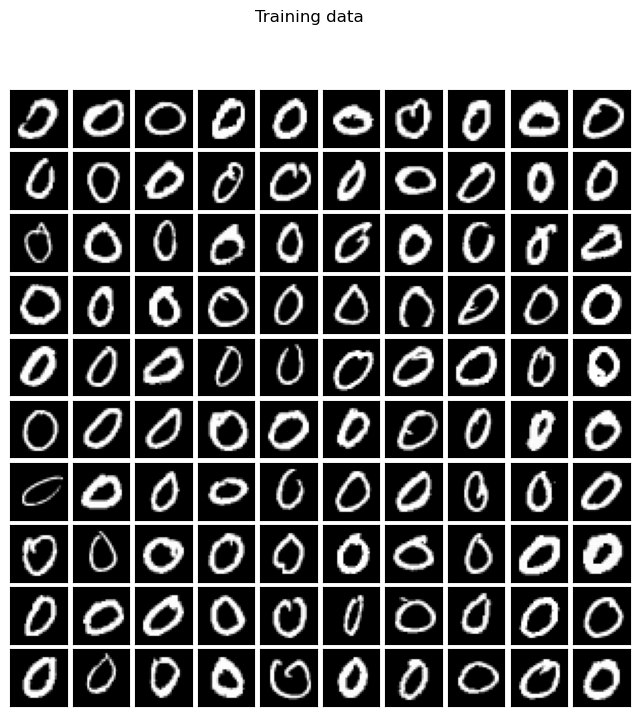

In [5]:
samples = sample_from_null_hypothesis(100)

fig, axs = plt.subplots(10, 10, figsize=(8, 8))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(samples[10 * i + j], cmap='gray', vmin=0, vmax=1)

## III. Test statistic

There are many ways to define test statistics. Foe instance, we can use average intensity or train a neural network to separate images.
Let us pursue both options.


In [6]:
def test_statistic_1(image):
    """
    Mean luminocity as a test statistic
    """
    return tf.reduce_mean(image)

Lets learn a classifier that separates zeros from all other number classes. There is no formal requirement how we choose a test statistic. In particular, we can train the classifier on all images forming the null hypothesis. This does not formally spoil further calculations that are needed to define statistical test. Nevertheless, it is not reasonable because our actionable null hypotheis is actually a surrogate to true null hypothesis we are interested in.      

**True null hypothesis:** The image patch is randomly chosen from the unseen images that that labelled as zero and that are close to MNIST  images.

Now if we train the model on MNIST data then the overfitting will shift the test statistic values. This will make the test less useful but it is still a statistical test. To make life easier, we ignore this detail. 

In [7]:
def mnist_logreg_model() -> keras.Model:
    """
    Returns initialised neural network for computing logistic regression on 28 x 28 greyscale images.
    """
    logreg = keras.Sequential(
        [
            layers.InputLayer((28, 28)),
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ],
        name="Logistic_regression"
    )
    logreg.build()
    return logreg

In [8]:
images = tf.concat([train_images, test_images], axis=0)
labels = tf.cast(tf.concat([train_labels, test_labels], axis=0) == 0, 'int32')

In [9]:
adam_lr = Adam(learning_rate=1e-3)
model = mnist_logreg_model()
model.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])
_ = model.fit(images, labels, epochs=10, batch_size=32, verbose=0)

In [10]:
def test_statistic_2(image):
    """
    Test statistic beased on logistic regression model
    """
    return model.predict(tf.expand_dims(image, axis=0), verbose=0)[0, 0]

Now we can evaluate test statistics on individual images 

In [11]:
print(f'The first test statistic:  {test_statistic_1(zeroes[0]):1.4f}')
print(f'The second test statistic: {test_statistic_2(zeroes[0]):1.4f}')

The first test statistic:  0.1555
The second test statistic: 0.9998


## III. P-value assignment

As a next step we need to assign a p-value for the test statistic according to the formulae given above. We could simulate the test statistic distribution by samping images from null hypothesis but we can be smarter -- we know that data distribution is a uniform distribution over all zero images. Hence, we can compute the distribution of test statistic by evaluating it on the entrire set of zeros and then constructing the corresponding histogram.

(0.0, 1.0)

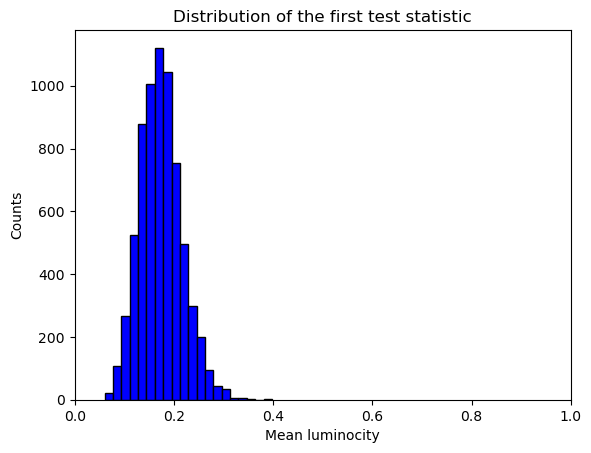

In [12]:
tvalues = tf.map_fn(test_statistic_1, zeroes)
plt.hist(tvalues, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of the first test statistic')
plt.xlabel('Mean luminocity')
plt.ylabel('Counts')
plt.xlim(0, 1)

This code is untolerably slow as we evaluate model point by point.

(0.0, 1.0)

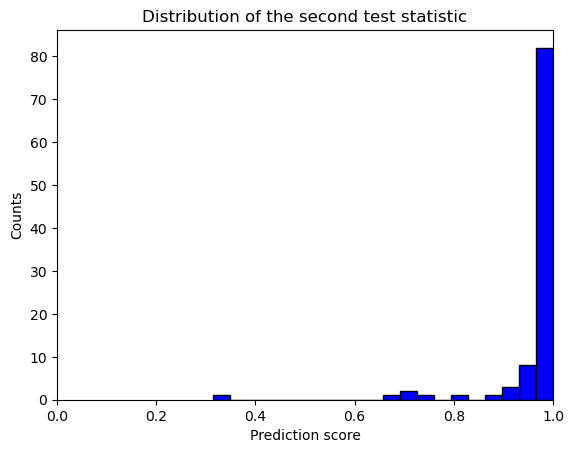

In [13]:
tvalues = tf.map_fn(test_statistic_2, zeroes[:100])
plt.hist(tvalues, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of the second test statistic')
plt.xlabel('Prediction score')
plt.ylabel('Counts')
plt.xlim(0, 1)

Let evaluate test statistic on the entire tensor at once.

(0.0, 1.0)

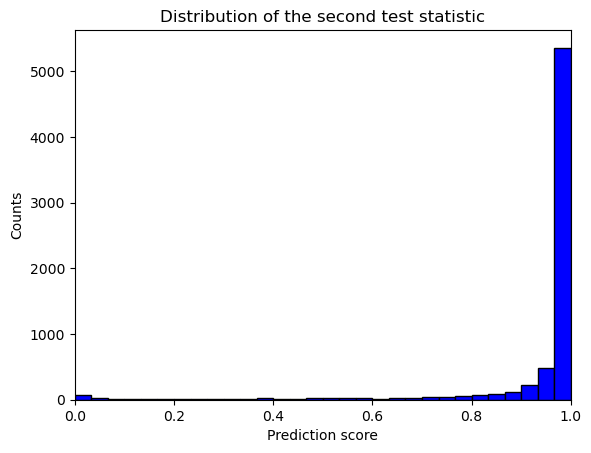

In [14]:
tvalues = tf.squeeze(model.predict(zeroes, verbose=0))
plt.hist(tvalues, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of the second test statistic')
plt.xlabel('Prediction score')
plt.ylabel('Counts')
plt.xlim(0, 1)

## IV. Choosing test type

Lets look how test statistics look on non-zero examples to see what kind of test type is best for our applications.

In [15]:
non_zeroes =  tf.concat([train_images[train_labels != 0], test_images[test_labels != 0]], axis=0)

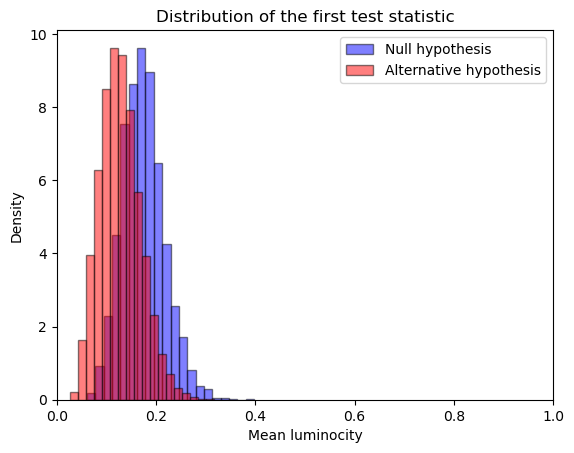

In [16]:
tvalues_0 = tf.map_fn(test_statistic_1, zeroes)
tvalues_1 = tf.map_fn(test_statistic_1, non_zeroes)

plt.hist(tvalues_0, bins=20, density=True, color='blue', edgecolor='black', alpha=0.5, label='Null hypothesis')
plt.hist(tvalues_1, bins=20, density=True, color='red', edgecolor='black', alpha=0.5, label='Alternative hypothesis')

plt.title('Distribution of the first test statistic')
plt.xlabel('Mean luminocity')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.legend()
plt.show()

**Judgement** 
* For the first statistic, we should use one-sided test and compute probability $t\leq t_*$ for simulated $t_*$.
* Test statistic does not separate well the null hypothesis from the alternative hypothesis.
* The latter means that the test will not be powerful -- creates a lot of false negatives.  

In [17]:
tvalues_0 = tf.squeeze(model.predict(zeroes, verbose=0))
tvalues_1 = tf.squeeze(model.predict(non_zeroes, verbose=0))

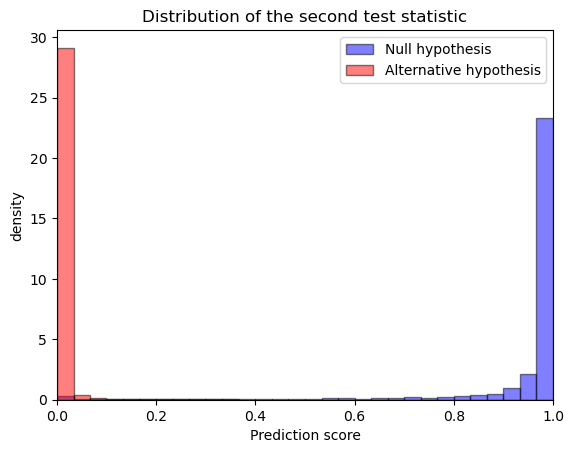

In [18]:
plt.hist(tvalues_0, bins=30, density=True, color='blue', edgecolor='black', alpha=0.5, label='Null hypothesis')
plt.hist(tvalues_1, bins=30, density=True, color='red', edgecolor='black', alpha=0.5, label='Alternative hypothesis')

plt.title('Distribution of the second test statistic')
plt.xlabel('Prediction score')
plt.ylabel('density')
plt.xlim(0, 1)
plt.legend()
plt.show()

**Judgement** 
* For the first statistic, we should use one-sided test and compute probability $t_*\leq t$ for simulated $t_*$.
* Test statistic separate well the null hypothesis from the alternative hypothesis.
* The latter means that the test will be powerful -- false negatives are really rare.  

# Homework

## 2.1 Properties of p-values (<font color='red'>1p</font>)

Finalise statistical tests for both test statistics defined above, i.e., define two functions that returns value of test statistic and corresponding p-value. Verify that p-values have uniform distribution when null hypothesis holds. For that you can compute deciles of all p-values and verify that they close to the range $0.1,0.2,\ldots, 0.9$. Explain why p-value is uniformly distributed when null hypothesis holds. 


**Hint:** You can use `np.mean` or `tf.reduce_mean` to compute the fraction of list elements satisfying test statistic constraints. 

## 2.2 Power of a statistical test (<font color='red'>1p</font>)

Consider two statistical tests defined in the previous exercise. Fix a standard significance level $5\%$, i.e., reject null hypothesis if p-value is below $5\%$. Estimate how big fraction of nonzero images have p-values that are larger than $5\%$, i.e., are considered as false negatives. Which test is better and why? Is this result universal or it is possible to device a scenarios where the roles switch?  

**Bonus:** Draw the graph where on $x$-axis is significance level and on $y$-axis is the fraction of false negatives. What does this graph resemble modulo flipping and mirroring? (<font color='red'>0.5p</font>).